In [1]:
from preamble import *
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv('./data/j_before_feature_importance.csv')

In [3]:
def create_sequences(data, seq_length, target_length):
  Xs = []
  ys = []
  for i in range(len(data) - seq_length - target_length + 1):
    X = data[i:(i + seq_length)].drop('outflow', axis=1).values
    y = data['outflow'].values[i + seq_length: i+ seq_length + target_length]
    Xs.append(X)
    ys.append(y)
  return np.array(Xs), np.array(ys)

In [4]:
SEQ_LENGTH = 168  # 과거 7일 (시간 단위)
TARGET_LENGTH = 1 # 이후 1시간 예측

X, y = create_sequences(df, SEQ_LENGTH, TARGET_LENGTH)

In [18]:
X[0].shape, y[0].shape

((168, 32), (1,))

In [19]:
model_filename = './model/1hour_xgboost_all_features_model.json'
model = xgb.Booster(model_file=model_filename)
print(model)

In [20]:
from tqdm import tqdm

def recursive_forecast(model, past_data, n_forecast=24):
  """
  XGBoost 모델을 사용하여 반복적으로 24시간을 예측합니다.

  Args:
      model: 학습된 XGBoost 모델.
      past_data: 168개(일주일)의 과거 데이터 (numpy array).
      n_forecast: 예측할 시간 수 (default: 24).

  Returns:
      forecasts: 24개의 예측값을 담은 numpy array.
  """

  forecasts = []
  current_data = past_data.copy()  # 복사본을 사용

  for i in tqdm(range(n_forecast)):
    # 1. 현재 데이터를 모델에 입력하여 다음 1시간을 예측
    #   - 입력 데이터의 형태는 모델 학습 시 사용한 형태와 동일해야 합니다.
    #   -  예: (1, 168) 또는 (1, 168, n_features)  (n_features는 feature 개수)
    #   -  여기서는 (1, 168) 형태라고 가정합니다.
    dtest = xgb.DMatrix(current_data.reshape(1, -1))
    next_hour_prediction = model.predict(dtest)

    # 2. 예측값을 forecasts에 추가
    forecasts.append(next_hour_prediction)

    # 3. 현재 데이터를 업데이트: 마지막 167개 데이터 + 새로운 예측값
    current_data = np.append(current_data[1:], next_hour_prediction)
    print(current_data.shape)

  return np.array(forecasts)

In [22]:
dtest = xgb.DMatrix(X[0].reshape(1, -1))
next_hour_prediction = model.predict(dtest)
print(next_hour_prediction)

[137.601]


In [23]:
X[0].shape

(168, 32)

In [24]:
y_pred = recursive_forecast(model, X[0])
y_pred.shape

100%|██████████| 24/24 [00:00<00:00, 216.80it/s]

(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)
(5345,)


(24, 1)

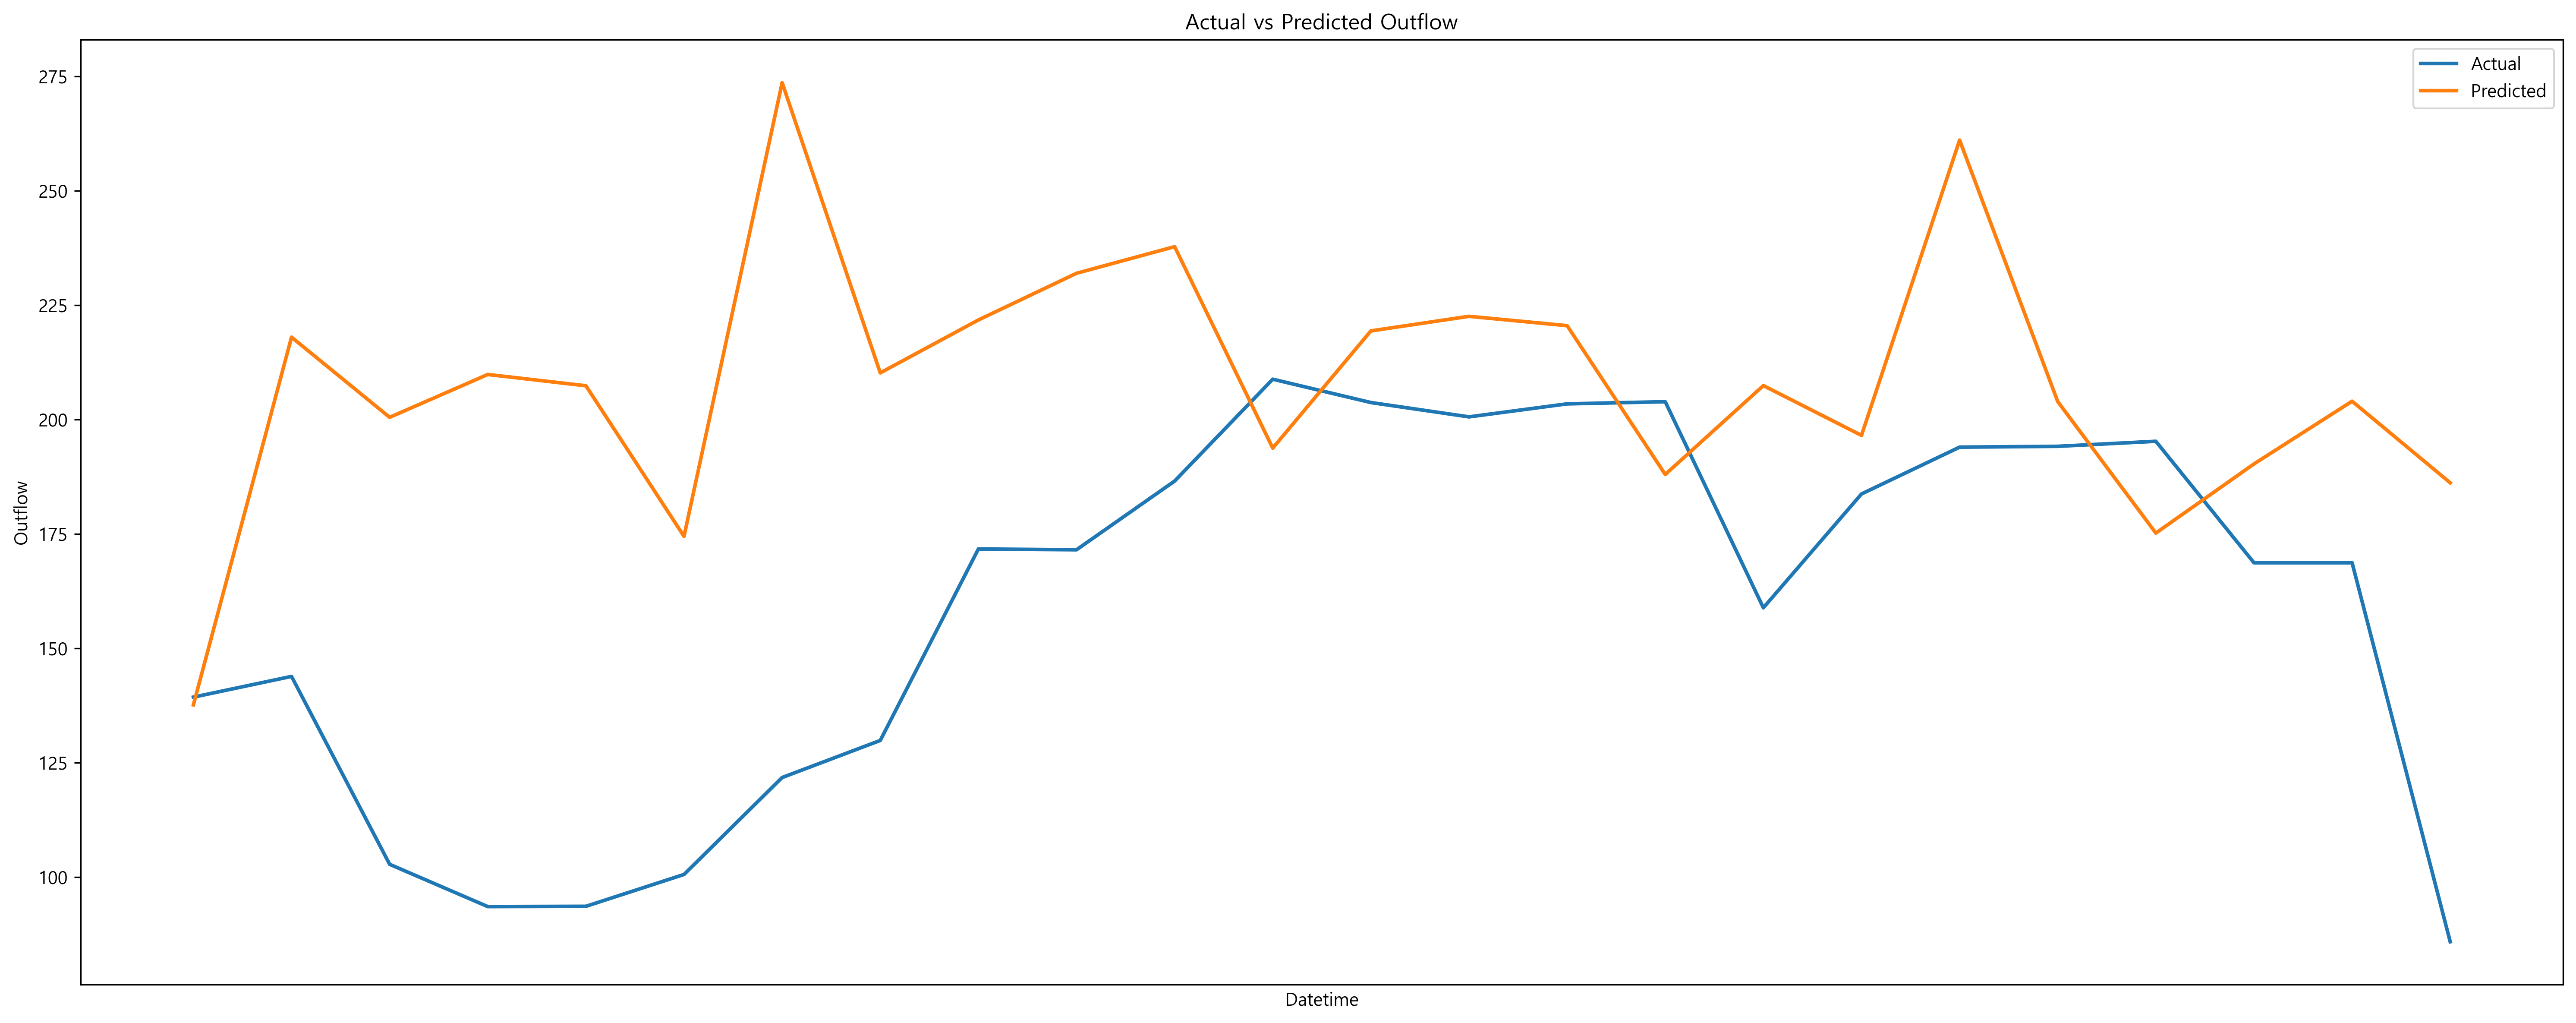

In [ ]:
data = pd.read_csv('./data/j_before_feature_importance_with_datetime.csv')

# 시각화
plt.figure(figsize=(20, 8))

# datetime 범위 생성
datetime_range = data['datetime'][168:168+24].values
y_actual = data['outflow'][168:168+24].values

# 시각화
plt.plot(datetime_range, y_actual, label='Actual')
plt.plot(datetime_range, y_pred, label='Predicted')

plt.xticks([])  # x축 눈금 제거
plt.xlabel('Datetime')
plt.ylabel('Outflow')
plt.title('Actual vs Predicted Outflow')
plt.legend()
plt.tight_layout()        # 레이아웃 조정
plt.show()

In [ ]:
def plot_predictions_weekly(y_true, y_pred, datetime_data, start_index, plot_title):
  plt.figure(figsize=(20, 6))

  # datetime 범위 추출
  datetime_range = datetime_data[start_index:start_index + 168].values  # 일주일 (168시간)

  # 예측값과 실제값 범위 조정
  y_true_plot = y_true[:168]
  y_pred_plot = y_pred[:168]

  plt.plot(y_true_plot, label='Actual')
  plt.plot(y_pred_plot, label='Predicted')

  plt.xlabel('Datetime')
  plt.ylabel('Outflow')
  plt.title(plot_title)
  plt.legend()
  plt.xticks([])  # x축 레이블 생략
  plt.tight_layout()
  plt.show()

# 초반 일주일 시각화
start_index_start = train_size + SEQ_LENGTH
plot_predictions_weekly(y_test, y_pred, data['datetime'], start_index_start, 'First Week Predictions')

# 마지막 일주일 시각화
start_index_end = train_size + SEQ_LENGTH + len(y_test) - 168 # 마지막 168시간을 맞추기 위해 index 조정
plot_predictions_weekly(y_test[-168:], y_pred[-168:], data['datetime'], len(data) - 168, 'Last Week Predictions')